In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import torch
import time
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import plotly_express as px
import plotly.figure_factory as ff
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm


SEED = 42

In [2]:
projects = pd.read_csv("../data/nrao_projects.csv")
projects = projects.set_index('project_code')

In [3]:
line_projects = projects.query('fs_type == "line"')
line_projects.shape

(3628, 12)

In [4]:
measurements = pd.read_csv('../../nrao_measurements.csv')
measurements = measurements.set_index('project_code')
measurements = measurements[measurements.fs_type == 'line']

## Remove outliers from projects and measurements

See 'Identifying_High_Measurement_Projects.ipynb' in 'data' folder

From this notebook, any project with > 26.5 measurements is an outlier

In [5]:
project_measurements = measurements.groupby(measurements.index)\
    .project_title.count()\
        .sort_values(ascending=False)\
        .to_frame()
project_measurements.columns = ['measurement_count']
project_measurements.head()

,measurement_count
project_code,
2017.1.00161.L,289
2017.1.00886.L,283
2021.2.00052.S,265
2023.1.00963.S,253
2022.1.00224.S,188


In [6]:
outliers = project_measurements[project_measurements.measurement_count > 26.5]

In [7]:
measurements = measurements.loc[~measurements.index.isin(outliers.index)]
line_projects = line_projects.loc[~line_projects.index.isin(outliers.index)]

### Sort frames by index

In [8]:
measurements = measurements.sort_index(ascending=True)
line_projects = line_projects.sort_index(ascending=True)

### Use KNN to find $\epsilon$ for DBSCAN
The DBSCAN papers suggest using the elbow method with $k=2*\text{num dimensions}-1$ to find the optimal $\epsilon$

In our case since we're only using 1 dimension we use $k=2$

In [9]:
X = np.array(measurements.med_freq)
X = X.reshape(-1, 1)
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

# next, we sort and plot the results
distances = np.sort(distances, axis=0)
distances = distances[:,1]

# Plot
fig = px.scatter(
    distances, 
    title='Distance Curve')
fig.update_xaxes(title_text='Distances')
fig.update_yaxes(title_text='Distance threashold (espsilon)')
fig.show()

In [10]:
#db = DBSCAN(eps=0.145, min_samples=2).fit(list(zip(measurements.med_freq)))
db = DBSCAN(eps=0.05, min_samples=10).fit(list(zip(measurements.med_freq)))

### Summarize and visualize DBSCAN results

In [11]:
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_points = len(list(labels))
n_noise = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters)
print("Total number of measurements: %d" % n_points)
print("Estimated number of noise measurements: %d" % n_noise)
print(f"Noise percentage: {round(list(labels).count(-1)/labels.shape[0], 3)}")
print(f'Signal to noise ratio: {1-round(list(labels).count(-1)/labels.shape[0], 3)}')

Estimated number of clusters: 320
Total number of measurements: 25051
Estimated number of noise measurements: 5763
Noise percentage: 0.23
Signal to noise ratio: 0.77


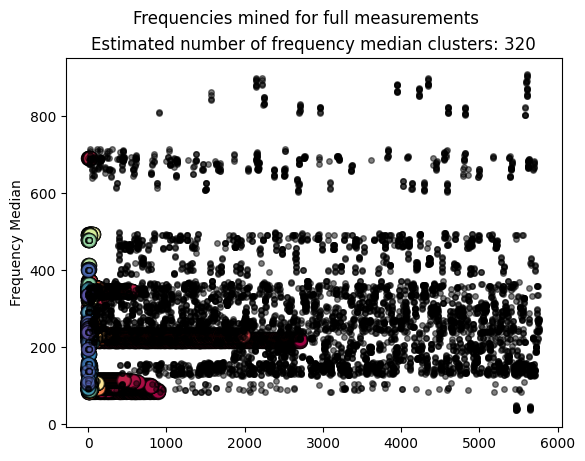

In [12]:
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True


colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:],
        #xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=10,
        alpha=0.5
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:],
        #xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=4,
        alpha=0.5
    )

plt.title(f"Estimated number of frequency median clusters: {n_clusters}")
plt.ylabel('Frequency Median')
plt.suptitle(f"Frequencies mined for full measurements")
plt.show()

### Assign labels to measurements for topic and describe clusters
We need to add one since 'noise' not accounted for by a DBSCAN cluster are labeled -1 and we will want to index an array later by cluster label.

In [13]:
measurements['cluster'] = db.labels_ + 1

In [14]:
measurements.groupby('cluster').count().project_title.sort_values(ascending=False).head(20)

cluster
0      5763
3      2715
39     1989
4       905
8       815
7       740
9       641
10      584
16      576
19      458
11      351
72      274
5       257
15      246
29      203
70      196
23      183
6       169
1       144
101     141
Name: project_title, dtype: int64

In [15]:
measurements.groupby('cluster').count().project_title.describe()

count     321.000000
mean       78.040498
std       382.229130
min         2.000000
25%        13.000000
50%        19.000000
75%        34.000000
max      5763.000000
Name: project_title, dtype: float64

In [16]:
measurements[measurements.cluster == 39].med_freq.describe()

count    1989.000000
mean      230.691757
std         0.745880
min       228.930000
25%       230.420000
50%       230.540000
75%       231.265000
max       232.310000
Name: med_freq, dtype: float64

/Users/ryanlipps/miniconda3/envs/nraotest/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/ryanlipps/miniconda3/envs/nraotest/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



<Axes: xlabel='med_freq', ylabel='Density'>

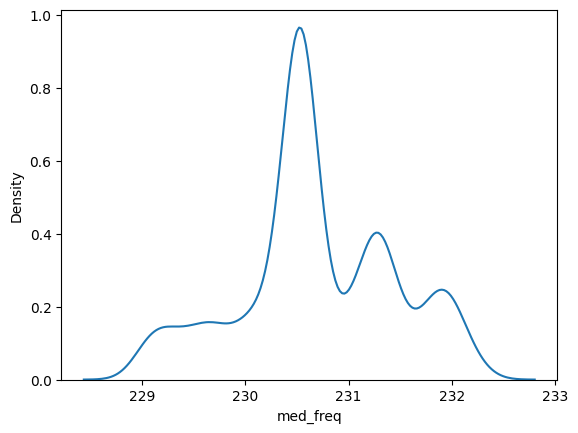

In [17]:
sns.kdeplot(measurements[measurements.cluster == 39].med_freq)

### Create ground-truth vectors for DBSCAN cluster by project

#### Group by project id

In [18]:
proj_meas = measurements.groupby('project_code').agg({
    'cluster': lambda x: x.to_list()
})

In [19]:
def generate_gt(frame:pd.DataFrame, label_column:str, labs:np.array, normalize=True): 
    '''
    Function that generates ground truth vectors for projects by taking a data frame,
    a string representing the column name that has a list of labels for each measurement,
    and the raw lables from a clustering algorithm

    PARAMETERS:
    
    frame: `pd.DataFrame` indexed by project_code that has a column with list of measurment labels

    label_column: `str` name of column to base ground truth vector off of

    labs: `np.ndarray` of lables generated by clustering algorithm

    normalize: `bool` to normalize vector by sum of values to get probability vector. Defaults to `True`

    OUTPUTS:

    gt_list: `list` of `np.array` ground truth vectors
    '''  
    # gt_list = []
    # for proj in frame.index.values:
    #     arr = np.zeros(len(set(list(labs))))
    #     proj_labs = pd.Series(frame.loc[proj][label_column]).value_counts()
    #     for idx in proj_labs.index:
    #         arr[idx] = proj_labs[idx]
    #     if normalize:
    #         arr = arr/arr.sum()
    #     gt_list.append(np.array(arr))
    # return gt_list

    gt_dict = {}
    for proj in frame.index.values:
        arr = np.zeros(len(set(list(labs))))
        proj_labs = pd.Series(frame.loc[proj][label_column]).value_counts()
        for idx in proj_labs.index:
            arr[idx] = proj_labs[idx]
        if normalize:
            arr = arr/arr.sum()
        gt_dict[proj] = np.array(arr)
    return gt_dict

#### Check that we ground truth vectors for number of projects

In [20]:
ground_truth = generate_gt(proj_meas, 'cluster', db.labels_, normalize=True)
len(ground_truth)

3284

In [21]:
gt_frame = pd.DataFrame(ground_truth).sort_index(ascending=True).T
gt_frame

,0,1,2,3,4,5,6,7,8,9,...,311,312,313,314,315,316,317,318,319,320
2011.0.00010.S,0.050000,0.1000,0.05,0.2,0.200,0.0500,0.05,0.050,0.050,0.100,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011.0.00017.S,0.062500,0.0625,0.00,0.0,0.125,0.0625,0.00,0.125,0.125,0.125,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011.0.00028.S,0.000000,0.0000,0.00,0.0,0.000,0.0000,0.00,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011.0.00039.S,1.000000,0.0000,0.00,0.0,0.000,0.0000,0.00,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011.0.00046.S,0.000000,0.0000,0.00,0.0,0.000,0.0000,0.00,0.000,0.250,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023.1.01710.S,0.000000,0.0000,0.00,0.0,0.000,0.0000,0.00,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023.1.01720.S,0.166667,0.0000,0.00,0.5,0.000,0.0000,0.00,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023.1.01721.S,0.000000,0.0000,0.00,0.0,0.000,0.0000,0.00,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023.A.00003.S,0.500000,0.0000,0.00,0.0,0.000,0.0000,0.00,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Add ground truth labels to projects

In [22]:
gt_frame = gt_frame.apply(lambda x: x.to_list(), axis=1).to_frame()

In [23]:
gt_frame.columns = ['gt_vec']
gt_frame.head()

,gt_vec
2011.0.00010.S,"[0.05, 0.1, 0.05, 0.2, 0.2, 0.05, 0.05, 0.05, ..."
2011.0.00017.S,"[0.0625, 0.0625, 0.0, 0.0, 0.125, 0.0625, 0.0,..."
2011.0.00028.S,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2011.0.00039.S,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2011.0.00046.S,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25,..."


#### Generate small dataframe to be fed to BERT

In [24]:
bert_input = pd.merge(line_projects[['standardized_text']], gt_frame, left_index=True, right_index=True)
bert_input.head()

,standardized_text,gt_vec
project_code,,
2011.0.00010.S,the physics and chemisty of gas in centaurus a...,"[0.05, 0.1, 0.05, 0.2, 0.2, 0.05, 0.05, 0.05, ..."
2011.0.00017.S,expanding the frontiers of chemical complexity...,"[0.0625, 0.0625, 0.0, 0.0, 0.125, 0.0625, 0.0,..."
2011.0.00028.S,the effect of extreme environment on protoplan...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2011.0.00039.S,the view of the cool dust in an extreme low me...,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2011.0.00046.S,the first insight into the resolved molecular ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25,..."


## Begin BERT

In [25]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Replace NaN values in the 'standardized_text' column with an empty string
bert_input['standardized_text'] = bert_input['standardized_text'].fillna('')

# Tokenize all of the sentences and map the tokens to thier word IDs
input_ids = []
attention_masks = []
# ma
# For every sentence...
for sent in bert_input.standardized_text:
    # `encode_plus` will:
    #   (1) Tokenize the sentence
    #   (2) Prepend the `[CLS]` token to the start
    #   (3) Append the `[SEP]` token to the end
    #   (4) Map tokens to their IDs
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 250,           # Pad & truncate all sentences
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks
                        return_tensors = 'pt',     # Return pytorch tensors
                   )

    # Add the encoded sentence to the list
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding)
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(bert_input.gt_vec.tolist())

print('Original: ', bert_input.standardized_text[0])
print('Token IDs:', input_ids[0])


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/Users/ryanlipps/miniconda3/envs/nraotest/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).



Original:  the physics and chemisty of gas in centaurus a and its host v centaurus a with its host ngc is the most nearby radio galaxy its molecular spectrum exhibits three prominent features a gas that is located in the outer disk and dust lanes b absorption lines that are supposedly close to the central agn and c gas in emission from the nucleus we propose to observe the absorption system in a variety of molecular lines the molecular lines are chosen to be tracers of column and volume density temperature photon and x ray dominated regions x ray dominated regions are a crucial marker for gas close to the supermassive black hole shocks and excitation conditions this will allow us to derive the physical state of the gas at each spectral component as well as the chemistry involved our goal is to derive the origin and physics of each absorption component reaching from the central black hole through the region that supplies the supermassive black hole with material regions of possible infa

/var/folders/vx/9pb2fpkj3m5bkbwxzyx6sz5m0000gn/T/ipykernel_17985/4264940452.py:40: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [26]:
# Splitting Data by 25%
# Masks in BERT models indicate which tokens to pay attention to

# train_inputs, validation_inputs: Tokenized and encoded text data split into training and validation sets.
# train_labels, validation_labels: Corresponding labels for training and validation sets, representing the target frequency setups.
# train_masks, validation_masks: Attention masks for training and validation sets to indicate which tokens the model should focus on.

# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=2018, test_size=0.25)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=2018, test_size=0.25)

print("Training Set:", len(train_inputs))
print("Validation Set:", len(validation_inputs))

Training Set: 2463
Validation Set: 821


In [27]:
batch_size = 32

# Create the DataLoader for the training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for the validation set
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

print("Dataloaders created for training and validation sets.")

Dataloaders created for training and validation sets.


In [28]:
num_classes = train_labels.shape[1]
num_classes

321

In [29]:
adjusted_learning_rate = 5e-5
num_training_steps = len(train_dataloader) * 4
num_warmup_steps = num_training_steps * 0.1

In [30]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top.
# model = BertForSequenceClassification.from_pretrained(
#     "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
#     num_labels = 854, # The number of output labels--2 for binary classification.
#                                         # You can increase this for multi-class tasks.
#     output_attentions = False, # Whether the model returns attentions weights.
#     output_hidden_states = False, # Whether the model returns all hidden-states.
# )

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=num_classes,
    output_attentions=False,
    output_hidden_states=False,
)

# Tell pytorch to run this model on the GPU.
model.cpu()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

### Change final output layer of BERT to softmax to get probability vectors out

In [31]:
# model.classifier = torch.nn.Sequential(
#     torch.nn.Linear(in_features=768, out_features=321, bias=True),
#     torch.nn.Softmax(321)
# )
# print(model)

In [32]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
criterion = torch.nn.CrossEntropyLoss()

/Users/ryanlipps/miniconda3/envs/nraotest/lib/python3.11/site-packages/transformers/optimization.py:457: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning



In [33]:
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [35]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Now, before you start your training loop, define a starting time:
t0 = time.time()

In [44]:
device = torch.device('mps')
model.to(device)


def train_model(model, train_dataloader, epochs=4):
    model.train()  # Put the model in training mode
    for epoch_i in range(epochs):
        print(f'\n======== Epoch {epoch_i + 1} / {epochs} ========')
        print('Training...')
        total_loss = 0
        total_accuracy = 0  # Initialize total accuracy for the epoch

        for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
            b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
            model.zero_grad()

            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            # Calculate accuracy
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            total_accuracy += criterion(torch.from_numpy(logits), torch.from_numpy(label_ids))

        avg_train_loss = total_loss / len(train_dataloader)
        avg_train_accuracy = total_accuracy / len(train_dataloader)  # Calculate the average accuracy over all batches

        print(f"  Average training loss: {avg_train_loss:.2f}")
        print(f"  Average training accuracy: {avg_train_accuracy:.2f}")
        # Optionally, you can add code here to track and print other metrics

In [40]:
def validate_model(model, validation_dataloader):
    print("\nRunning Validation...")
    model.eval()  # Put the model in evaluation mode
    eval_accuracy = 0
    nb_eval_steps = 0
    for batch in validation_dataloader:
        b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        logits = outputs.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        tmp_eval_accuracy = criterion(torch.from_numpy(logits), torch.from_numpy(label_ids))
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1
    print(f"  Accuracy: {eval_accuracy/nb_eval_steps:.2f}")
    # Optionally, add code here to calculate and print other metrics such as F1 score, if desired

In [45]:
# Train the model
train_model(model, train_dataloader, epochs=4)


======== Epoch 1 / 4 ========
Training...


100%|██████████| 77/77 [02:13<00:00,  1.74s/it]


  Average training loss: 0.50
  Average training accuracy: 5.89

======== Epoch 2 / 4 ========
Training...


100%|██████████| 77/77 [02:11<00:00,  1.71s/it]


  Average training loss: 0.25
  Average training accuracy: 5.79

======== Epoch 3 / 4 ========
Training...


 16%|█▌        | 12/77 [00:21<01:56,  1.79s/it]


KeyboardInterrupt: 

In [ ]:
# Test the model
validate_model(model, validation_dataloader, epochs=4)